In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation

In [10]:
g=CoinGameSimulation()
g.reset()

(0, 0, 100)

Cheaters are only biased against heads!

In [3]:
def simulate_strategy(strategy, n_simulations=500):
    # Simulate the game with the given strategy
    # strategy is a function that takes n_heads, n_tails and flips_left and returns an action in ("fair", "cheater", "one_flip", "five_flips")
    g = CoinGameSimulation()
    scores = []
    n_labels_list = []
    n_flips_list = []
    n_flips_per_label_list = []
    rewards = []
    for _ in range(n_simulations):
        n_heads, n_tails, flips_left = g.reset()
        n_labels = 0
        n_flips = 0
        n_flips_per_label = 0
        done = g.done
        while not done:
            action = strategy(n_heads, n_tails, flips_left)
            (n_heads, n_tails, flips_left), reward, done, _ = g.step(action)
            rewards.append(reward)

            if action == 2:
                n_labels += 1
                n_flips_per_label_list.append(n_flips_per_label)
                n_flips_per_label = 0
            elif action == 3:
                n_labels += 1
                n_flips_per_label_list.append(n_flips_per_label)
                n_flips_per_label = 0
            elif action == 0:
                n_flips_per_label += 1
                n_flips += 1
            elif action == 1:
                n_flips_per_label += 5
                n_flips += 5
            else:
                raise ValueError("Unknown action: {}".format(action))
        scores.append(g.score)
        n_labels_list.append(n_labels)
        n_flips_list.append(n_flips)
    
    for name, l in zip(["score", "n_labels", "n_flips_per_game", "n_flips_per_label", "reward"],[scores, n_labels_list, n_flips_list, n_flips_per_label_list, rewards]):
        print(name, np.mean(l), "±", np.std(l))

### Baseline strategy
This is simply the random strategy to get a baseline of what to beat.

In [12]:
simulate_strategy(lambda *_: random.choice([2,3]))

score 6.92 ± 7.423314623535768
n_labels 14.088 ± 11.134821776750627
n_flips_per_game 0.0 ± 0.0
n_flips_per_label 0.0 ± 0.0
reward -7.896081771720613 ± 22.496513490541393


### Strategy 1
This stategy uses the [Binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) to determine the the coin to choose.

In [16]:
z = st.norm.ppf(.90)
p_fair = 0.5
p_cheater = 0.9

def strategy_binom_ci(n_heads, n_tails, flips_left):
    n = n_heads + n_tails
    if n == 0:
        return 1
    p_hat = n_heads / n

    p_hat_ci = z * np.sqrt(p_hat * (1 - p_hat) / n)

    if p_hat - p_hat_ci < p_fair < p_cheater + p_hat_ci:
        return 2
    
    if p_hat - p_hat_ci < p_cheater < p_cheater + p_hat_ci:
        return 3
    
    if flips_left <= 0:
        if abs(p_fair-p_hat) > abs(p_cheater-p_hat):
            return 2
        else:
            return 3
    
    return 0

simulate_strategy(strategy_binom_ci, n_simulations=1)

score 38.0 ± 0.0
n_labels 50.0 ± 0.0
n_flips_per_game 340.0 ± 0.0
n_flips_per_label 6.8 ± 7.691553809211765
reward -0.6842105263157895 ± 10.4128090733377


c:\Users\alber\Documents\My_Code\Primer_game\game.py:83: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


### Strategy 2: I try to reproduce my play.
This strategy tries to mimic the way I play the game in my head.

In [ ]:
def strategy_mimic_attempt(n_heads, n_tails, flips_left):
    n_throws = n_heads + n_tails
    diff = (n_heads-n_tails)
    if diff > 5:
        return 3
    elif diff < 0 or (n_throws > 10 and diff < 1):
        return 2
    if flips_left <= 0:
        if diff > 4:
            return 3
        else:
            return 2
    return 0

random.seed(1)
simulate_strategy(strategy_mimic_attempt, n_simulations=1000)

### Strategy 3: make use of Bayesian inference.
This strategy uses Bayesian inference to determine the best strategy to play.

The following wikipedia pages were used as reference 
[Checking whether a coin is fair](https://en.wikipedia.org/wiki/Checking_whether_a_coin_is_fair) and [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).

The following code shows the probabilitic graphical model for the coin flip distribution.

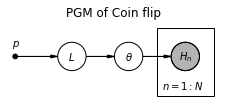

In [80]:
import daft

pgm = daft.PGM()
pgm.add_node("p", r"$p$", 0, 0, fixed=True, offset=(1, 5))
pgm.add_node("L", r"$L$", 1, 0)
pgm.add_node("theta", r"$\theta$", 2, 0)
pgm.add_node("H_n", r"$H_n$", 3, 0, observed=True)
pgm.add_edge("p", "L")
pgm.add_edge("L", "theta")
pgm.add_edge("theta", "H_n")
pgm.add_plate([2.5, -0.5, 1, 1], label=r"$n = 1:N$", shift=-0.2)
ax = pgm.render()
_ = ax.set_title("PGM of Coin flip")


Distributions:
- $L \sim$ Bernouilli distribution with unkown parameter p. Determines if the opponent is a cheater or not.
- $\theta \sim$ Unkown distribution with values $\in [0, 1]$. Gives parameters of the Bernoulli distribution of H.
- $H_{1:N}$: Bernouilli distribution with parameter $\theta$ and $N$ samples. Gives the number of heads.

$$P(L | H_{1:N}) = \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} $$

In [51]:
g = CoinGameSimulation()

In [ ]:
g.reset()

class StrategyBayseianInference:

    def __init__(self, n = 100, p_value=0.9):
        self.n = n      # how many values of theta we include
        self.p = 0.5
        self.thetha_L = np.ones((2, n)) / n

        self.p_value = p_value
        self.last_n_heads = 0
        self.last_n_tails = 0
    
    def __reset(self):
        n = self.n
        self.prior.fill(1/n)
        self.last_n_heads = 0
        self.last_n_tails = 0

    def strategy(self, n_heads, n_tails, flips_left):
        
        n_new_heads = n_heads - self.last_n_heads
        n_new_tails = n_tails - self.last_n_tails

        assert max(n_new_heads, n_new_tails) <= 1, f"{n_new_heads}, {n_new_tails}"
        assert min(n_new_heads, n_new_tails) == 0, f"{n_new_heads}, {n_new_tails}"

        theta = self.theta
        probability_of_observation = theta ** n_new_heads * (1 - theta) ** n_new_tails

        posterior = probability_of_observation * self.prior
        posterior /= np.sum(posterior)
        self.prior = posterior

        self.last_n_heads = n_heads
        self.last_n_tails = n_tails

        if n_heads + n_tails < 5:
            return 0

        p_fair = posterior[0.3 < theta].sum()
        p_cheater = posterior[0.5 < theta].sum()
        if p_fair > self.p_value:
            self.__reset()
            return 2
        if p_cheater > self.p_value:
            self.__reset()
            return 3

        if flips_left <= 0:
            self.__reset()
            if p_fair > p_cheater:
                return 2
            else:
                return 3
        
        return 0


strat = StrategyBayseianInference(p_value=0.81, n=100)
simulate_strategy(strat.strategy, n_simulations=1)

In [ ]:
g = CoinGameSimulation()
n = 100
prior = np.ones(n) / n
theta = np.linspace(0, 1, n)
p_value = 0.9

(n_heads, n_tails, flips_left), reward, done, _ = g.step(1)
last_n_heads, last_n_tails = 0,0
done = g.done
while not done:
    n_new_heads = n_heads - last_n_heads
    n_new_tails = n_tails - last_n_tails

    probability_of_observation = theta ** n_new_heads * (1 - theta) ** n_new_tails

    posterior = probability_of_observation * prior
    posterior /= np.sum(posterior)
    prior = posterior

    p_fair = posterior[(0.3 < theta)&(theta < 0.6)].sum()
    p_cheater = posterior[(0.5 < theta)&(theta < 1)].sum()

    n_thows = n_heads + n_tails
    print(f"{p_fair=} \n {p_cheater=} \n {flips_left=} \n {n_thows=} \n {n_heads=} \n {n_tails=}")
    plt.plot(theta, posterior)
    plt.show()
    time.sleep(2)
    clear_output(wait=True)

    last_n_heads = n_heads
    last_n_tails = n_tails

    (n_heads, n_tails, flips_left), reward, done, _ = g.step(0)

In [ ]:
g.reset()
for _ in range(20):
    (n_heads, n_tails, flips_left), reward, done, _ = g.step(1)
    time.sleep(0.1)
    print(f"{n_heads=}, {n_tails=}, {flips_left=}, {reward=}            ", end="\r")

In [ ]:
(n_heads, n_tails, flips_left), reward, done, _ = g.step(1)
print(f"{n_heads=}, {n_tails=}, {flips_left=}, {reward=} {done=}   ", end="\r")

### Strategy 4: make use of Q-learning.
This strategy uses Q-learning with an $\epsilon$-greedy policy to learn the best strategy to play.

The following wikipedia pages was used as a reference 
[Q learning](https://en.wikipedia.org/wiki/Q-learning).

$$
Q^{n e w}\left(s_{t}, a_{t}\right) \leftarrow \underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{r_{t}}_{\text {reward }}+\underbrace{\gamma}_{\text {discount factor }} \cdot \underbrace{\max _{a} Q\left(s_{t+1}, a\right)}_{\text {estimate of optimal future value }}-\underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }})}^{\text {temporal difference }}
$$

In [ ]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon = 0.05 # exploration rate
min_epsilon = 0.01
max_epsilon = 1
espilon_decay = 0.001

In [ ]:
env = CoinGameSimulation()
shape_of_state = tuple(d.n for d in env.observation_space[:-1])
Q_table = np.zeros((*shape_of_state, env.action_space.n))
scores = []
rewards = []
num_trained_episodes = 0
av_rewards = []

def epslion_greedy(state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

In [ ]:
num_episodes = 0
rewards = []

for itr in tqdm(range(num_episodes)):
    env.reset()
    (n_heads, n_tails, n_flips_left) = env.observe()
    state = (n_heads, n_tails)

    done = False
    while not done:
        move = epslion_greedy(state)
        (n_heads, n_tails, n_flips_left), reward, done, _  = env.step(move)
        next_state = (n_heads, n_tails)
        rewards.append(reward)
        
        Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state][move])

        state = next_state

    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-espilon_decay*itr)

    scores.append(env.score)
    av_rewards.append(np.sum(rewards))
    rewards = []      
    num_trained_episodes += 1
    env.reset()
clear_output(wait=True)
plt.plot(np.array(scores).reshape(1000,-1).mean(axis=0))
plt.show()

In [ ]:
epsilon

In [ ]:
np.argmax(Q_table[1,0])